Data loaded successfully from data/AAPL.csv
                               Open      High       Low     Close     Volume  \
Date                                                                           
2010-01-04 00:00:00-05:00  6.422877  6.455077  6.391278  6.440331  493729600   
2010-01-05 00:00:00-05:00  6.458087  6.487879  6.417460  6.451466  601904800   
2010-01-06 00:00:00-05:00  6.451466  6.477046  6.342226  6.348847  552160000   
2010-01-07 00:00:00-05:00  6.372319  6.379842  6.291066  6.337109  477131200   
2010-01-08 00:00:00-05:00  6.328683  6.379842  6.291368  6.379240  447610800   

                           Dividends  Stock Splits  
Date                                                
2010-01-04 00:00:00-05:00        0.0           0.0  
2010-01-05 00:00:00-05:00        0.0           0.0  
2010-01-06 00:00:00-05:00        0.0           0.0  
2010-01-07 00:00:00-05:00        0.0           0.0  
2010-01-08 00:00:00-05:00        0.0           0.0  


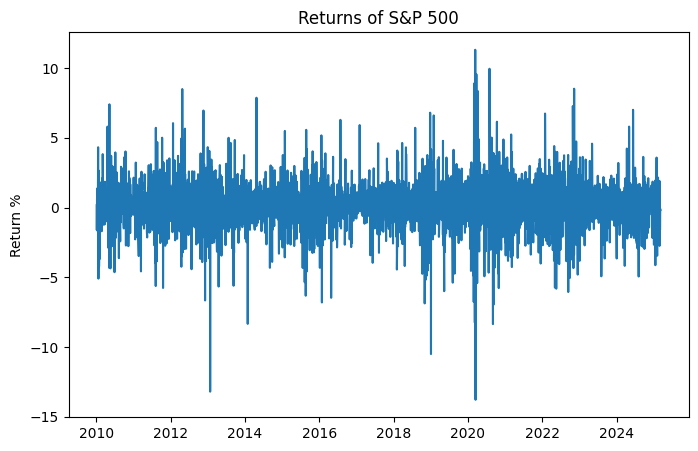

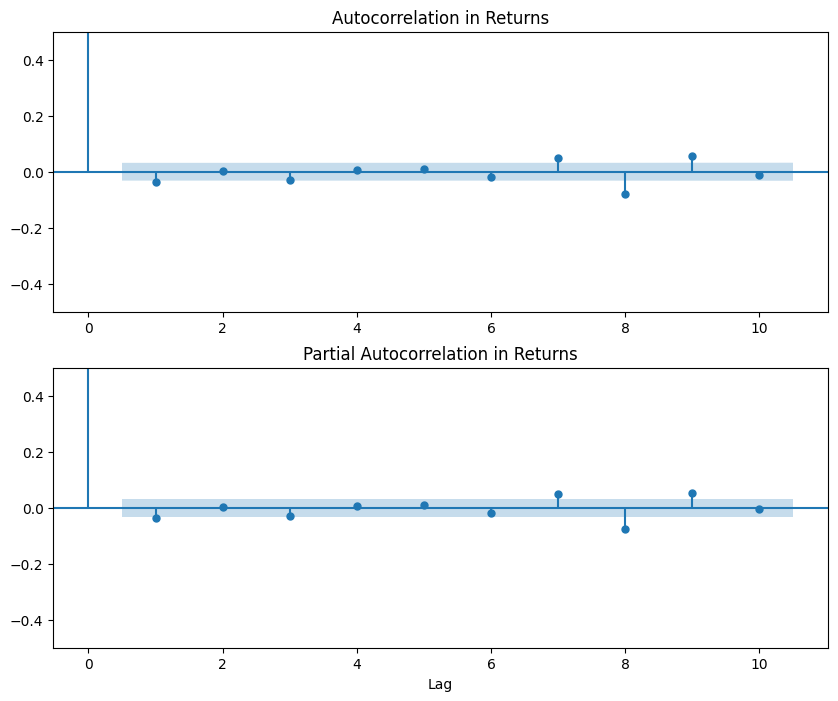

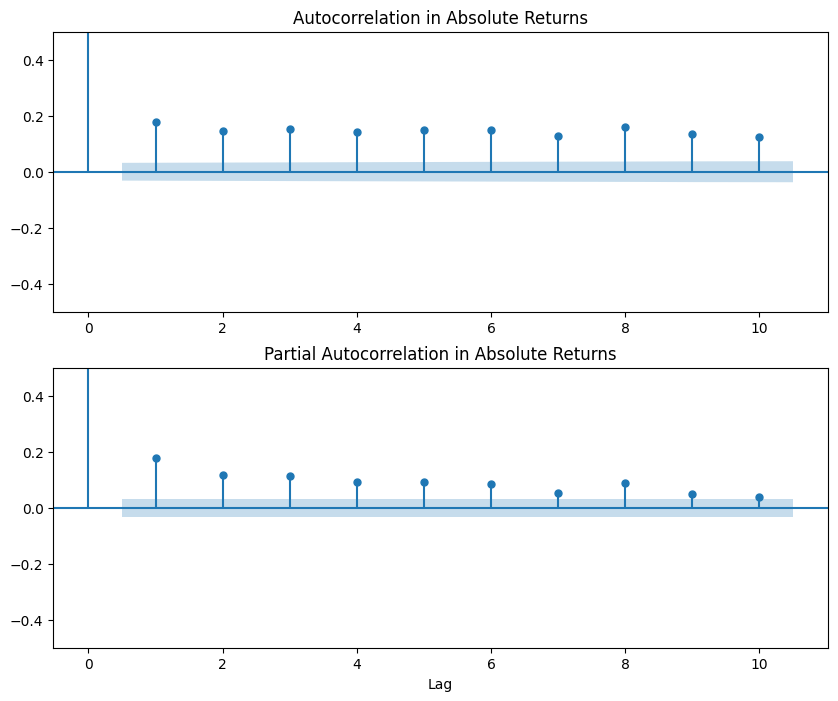

McLeod-Li test statistic:  931.4756801720932
p-value:  0.0
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5847.69
Distribution:                  Normal   AIC:                           11701.4
Method:            Maximum Likelihood   BIC:                           11719.5
                                        No. Observations:                 3052
Date:                Fri, Mar 07 2025   Df Residuals:                     3052
Time:                        12:33:37   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega

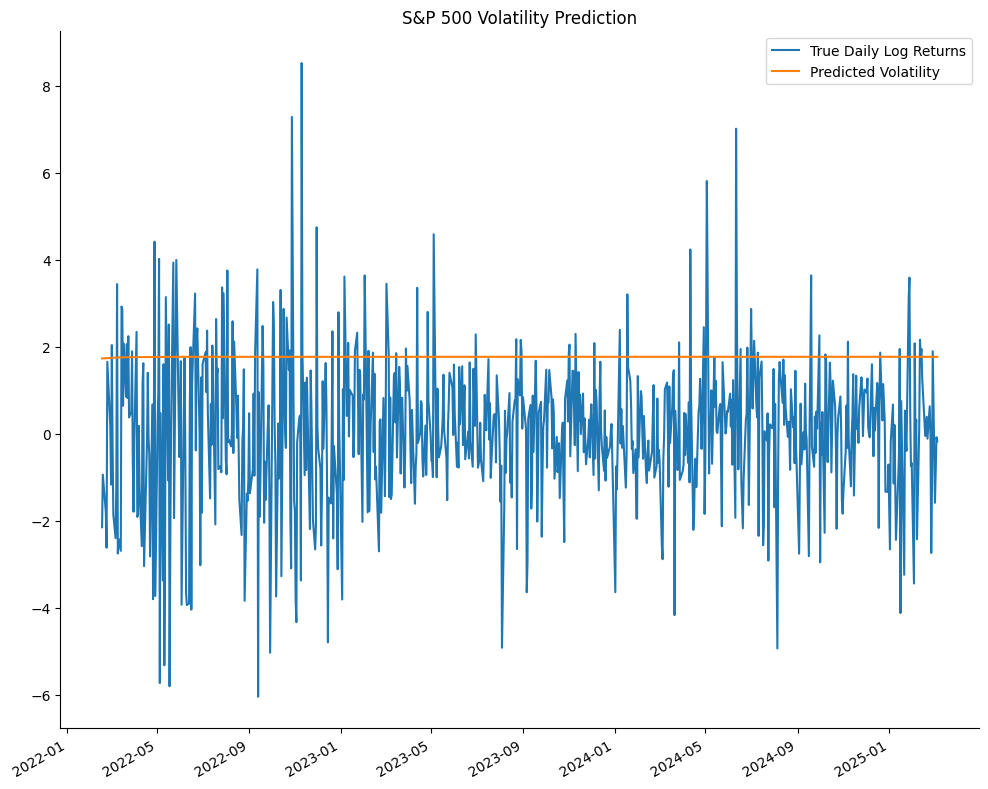

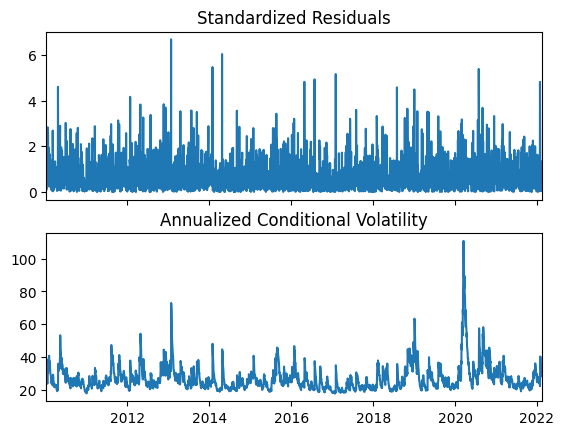

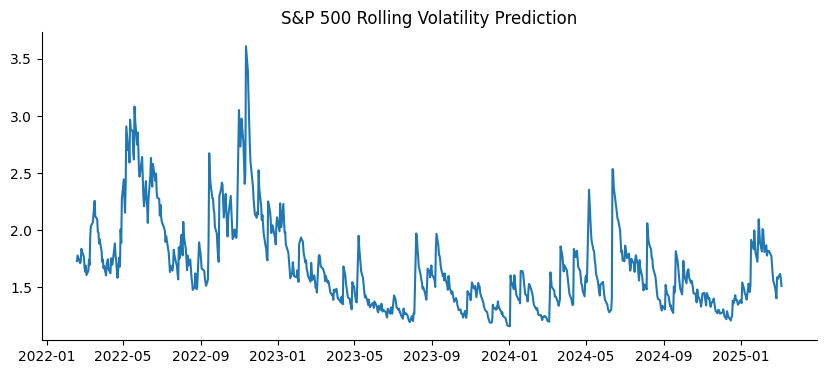

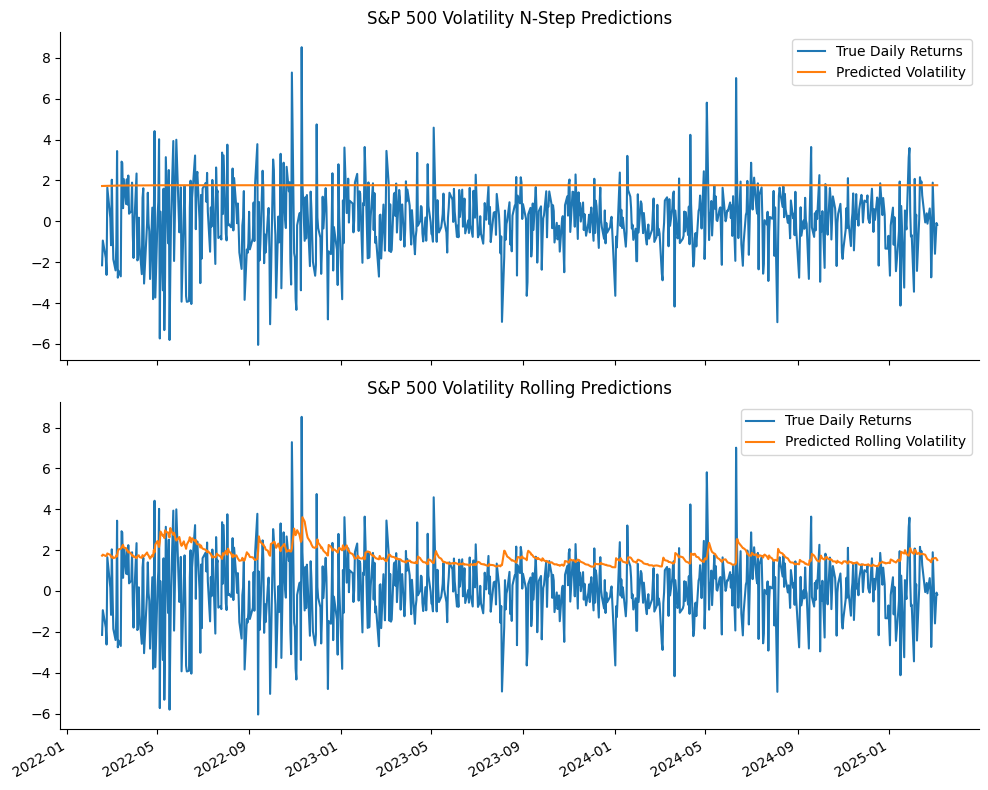

Jarque-Bera test statistic: 12213.993627872025
p-value: 0.0


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

from arch import arch_model
# import train test split from sklearn
from sklearn.model_selection import train_test_split
from scipy.stats import chi2, jarque_bera
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima.model import ARIMA

# ## Data Import

ticker = "AAPL"
csv_filepath = f"data/{ticker}.csv"

try:
    df = pd.read_csv(csv_filepath, index_col='Date', parse_dates=True)
    print(f"Data loaded successfully from {csv_filepath}")
except FileNotFoundError:
    print(f"Error: CSV file not found at {csv_filepath}. Please ensure the file exists in the 'data' folder.")
    print("Attempting to download data from yfinance instead...")
    spy = yf.Ticker(ticker)
    hist = spy.history(start = "2010-01-01", end = "2025-03-07")
    df = pd.DataFrame(hist, columns=['Close'])
    print("Data downloaded from yfinance.")

print(df.head())

# ## ARCH Model

# ## Exploratory Data Analysis
df['Return'] = np.pad(np.diff(np.log(df['Close'])) * 100, (1, 0), 'constant', constant_values=np.nan)

# **Trace Plot of Returns**
plt.figure(figsize=(8,5))
plt.plot(df['Return'])
plt.ylabel("Return %")
plt.title('Returns of S&P 500')
plt.show()

# **ACF and PACF of Returns**
diff_ts = df['Return'].iloc[1:]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(diff_ts.dropna(), ax=ax1, lags=10) #dropna() added to handle NaN
ax1.set_ylim(-0.5, .5)
ax1.set_title("Autocorrelation in Returns")
plot_pacf(diff_ts.dropna(), ax=ax2, lags=10) #dropna() added to handle NaN
ax2.set_ylim(-0.5, .5)
ax2.set_xlabel("Lag")
ax2.set_title("Partial Autocorrelation in Returns")
plt.show()

# **ACF and PACF of Absolute Returns**
abs_returns = diff_ts.abs().dropna() #dropna() added to handle NaN

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(abs_returns, ax=ax1, lags=10)
ax1.set_ylim(-.5, .5)
ax1.set_title("Autocorrelation in Absolute Returns")
plot_pacf(abs_returns, ax=ax2, lags=10)
ax2.set_ylim(-.5, .5)
ax2.set_title("Partial Autocorrelation in Absolute Returns")
ax2.set_xlabel("Lag")
plt.show()

# ## McLeod-Li Test

def mcleod_li_test(x, k):
    """
    Calculates the McLeod-Li test statistic for a time series with k lags.
    Returns the test statistic and its p-value.
    """
    n = len(x)
    x_sq = x ** 2
    acorr_sq = acf(x_sq, nlags=k)[1:] # Calculate ACF of squared series, skip lag 0
    test_stat = n * np.sum(acorr_sq**2)
    df = k
    p_value = 1 - chi2.cdf(test_stat, df)
    return test_stat, p_value

test_stat, p_value = mcleod_li_test(abs_returns, 10) # Using absolute returns as in the article, and 10 lags for example
print("McLeod-Li test statistic: ", test_stat)
print("p-value: ", p_value)

# ## Fit GARCH(1,1) Model

# **Data Split (80%/20%)**
train_size = int(len(abs_returns) * 0.8)
y_train = abs_returns[:train_size]
y_test = abs_returns[train_size:]

# **Fit GARCH (1,1) model**
garch_mod = arch_model(y_train, mean = "Zero",  vol='Garch', p=1, q=1, rescale=False)
res_garch = garch_mod.fit(disp='off') # disp='off' to suppress iteration output
print(res_garch.summary())

# ## Forecasting Volatility

# **N-Step Ahead Forecast**
yhat = res_garch.forecast(horizon=len(y_test), reindex=True)
fig, ax = plt.subplots(figsize=(10,8))
ax.spines[['top','right']].set_visible(False)
plt.plot(y_test.index, diff_ts[-len(y_test):].values)  # Use y_test.index for proper dates
plt.plot(y_test.index, np.sqrt(yhat.variance.values[-1,:]))
plt.title('S&P 500 Volatility Prediction')
plt.legend(['True Daily Log Returns', 'Predicted Volatility'])
fig.autofmt_xdate()  # Rotate and align the tick labels
plt.tight_layout()
plt.show()

# **Conditional volatility by model fitting**
res_garch.plot(annualize="D")
plt.show()

# **One-Step Ahead Rolling Forecast**
rolling_preds = []

for i in range(len(y_test)): # Iterate through y_test length
    train = abs_returns[:-(len(y_test)-i)] # Adjusted slicing
    model = arch_model(train, mean= 'Zero', vol='Garch', p=1, q=1, rescale = False) # mean='Zero' added
    model_fit = model.fit(disp='off')
    # One step ahead predictor
    pred = model_fit.forecast(horizon=1, reindex=True)
    rolling_preds.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_preds = pd.Series(rolling_preds, index=y_test.index)
# Plot of predicted test data rolling volatility predictions
fig,ax = plt.subplots(figsize=(10,4))
ax.spines[['top','right']].set_visible(False)
plt.plot(rolling_preds)
plt.title('S&P 500 Rolling Volatility Prediction')
plt.show()


# **Compare n-step-ahead and one-step-ahead rolling predictions**
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1.spines[['top','right']].set_visible(False)
ax1.plot(y_test.index, diff_ts[-len(y_test):].values)
ax1.plot(y_test.index, np.sqrt(yhat.variance.values[-1,:]))
ax1.set_title("S&P 500 Volatility N-Step Predictions")
ax1.legend(['True Daily Returns', 'Predicted Volatility'])

ax2.spines[['top','right']].set_visible(False)
ax2.plot(y_test.index, diff_ts[-len(y_test):].values)
ax2.plot(y_test.index, rolling_preds)
ax2.set_title("S&P 500 Volatility Rolling Predictions")
ax2.legend(['True Daily Returns', 'Predicted Rolling Volatility'])

# Improve x-axis readability
fig.autofmt_xdate()  # Rotate and align the tick labels
plt.tight_layout()
plt.show()

# ## Model Diagnostics

# Calculate the standardized residuals on the training data (as diagnostics are usually done on the training data)
std_resid = res_garch.resid / res_garch.conditional_volatility

# Perform Jarque-Bera test using scipy.stats
jb_test = jarque_bera(std_resid)
print("Jarque-Bera test statistic:", jb_test[0])
print("p-value:", jb_test[1])

